In [1]:
import os.path
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
import scipy
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.exposure import rescale_intensity
%matplotlib inline

# Convolution

Image convolution is an element-wise multiplication of two matrices followed by a sum.

1. Take two matrices
2. Multiply 
3. Sum

Some images also have depth, like an RGB image has depth of 3 for the red, green and blue channels. 

Image is our base matrix, and we take a smaller matrix (kernel/convolutional matrix) and slide it on top of the original image.

![Convolution matrix](https://i.imgur.com/7NcGa8R.png)

Kernel are of size M x N, where M,N are odd integers to make sure the result is a valid integer at the center.

## Load and visualize image

I'm using openCV for loading and handling images, and matplotplib to display the image in jupyter.

Notes:
* opencv uses BGR format, and matplotlib uses RGB so we have to convert BGR to RGB before displaying images.
* For RGB and RGBA images, Matplotlib supports float32 and uint8 data types. For grayscale, Matplotlib supports only float32. 
* Matplotlib plotting can handle float32 and uint8, but image reading/writing for any format other than PNG is limited to uint8 data. Why 8 bits? Most displays can only render 8 bits per channel worth of color gradation
* To stop matplotlib from adjusting pixel scale intensity for gray images, we should use 'cmap='gray', vmin = 0, vmax = 255' arguments.

Calculating padding:
$ P = \dfrac{(F-1)}{2} $, where F = filter size

In [2]:
class Convolution():
    def __init__(self, image_path: str):
        self.src_image = cv2.imread(image_path)
        self.image = cv2.cvtColor(self.src_image, cv2.COLOR_BGR2GRAY)
        self.conv_out = self.image
        
    def conv(self, filters: list):
        self.conv_out = self.image
    
        for _filter in filters:
            self.conv_out = self.__conv(_filter)
    
    def show_image(self):
        _, self.ax = plt.subplots(figsize=(10, 10))
        self.ax.imshow(self.image, cmap="gray", vmin = 0, vmax = 255)
        
    def show_conv(self):
        _, self.ax = plt.subplots(figsize=(10, 10))
        self.ax.imshow(self.conv_out, cmap="gray", vmin = 0, vmax = 255)
                
    def __conv(self, _filter):
        ZERO_PADDING = [0, 0, 0]
        
        img = self.conv_out
        image_height, image_width = self.conv_out.shape
        output = np.zeros(self.conv_out.shape, dtype="float32")
        
        _, filter_size = _filter.shape
        padding = (filter_size - 1) // 2
        
        img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=ZERO_PADDING)

        kernel = np.flip(_filter)
        
        for i in range(padding, image_height + padding):
            for j in range(padding, image_width + padding):
                center = img[i - padding:i + padding + 1, j - padding:j + padding + 1]
                conv_sum = (center * kernel).sum()

                output[i - padding, j - padding] = conv_sum
        
        return output.astype("uint8")

In [3]:
class Filter():
    def __init__(self, name, size):
        self.name = name
        self.size = size
        if name == 'blur' and size > 0:
            self.func = self.__blur(size)
            return
        
        raise ValueError('Filter not found')
        
    def get(self):
        return self.func
        
    def __blur(self, size):
        return np.ones((size, size), dtype="float") * (1.0 / (size * size))
    
    def __gauss(self):
        t = np.linspace(-10, 10, 30)
        bump = np.exp(-0.1*t**2)
        bump /= np.trapz(bump)

        kernel = bump[:, np.newaxis] * bump[np.newaxis, :]

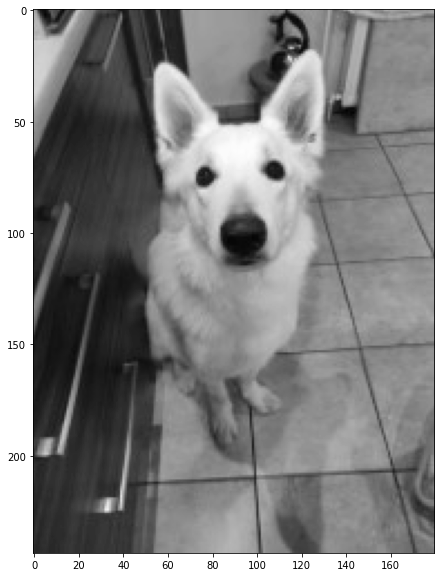

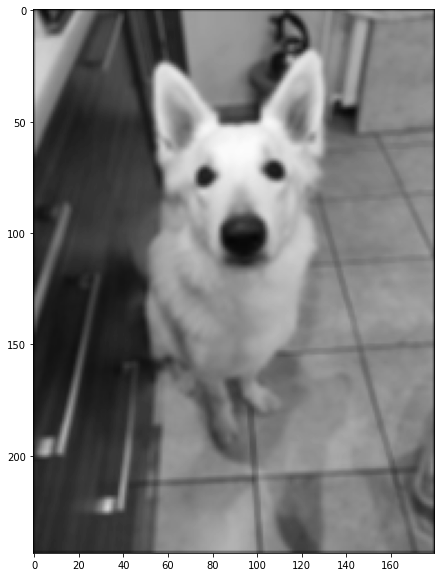

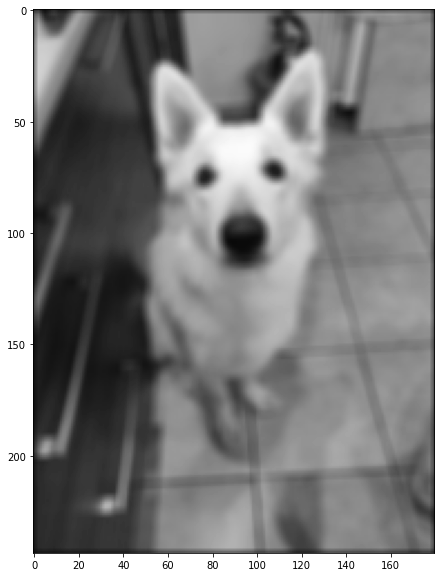

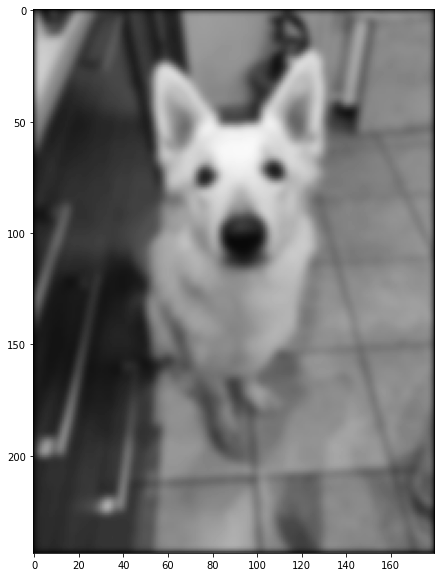

In [4]:
input_image = './example_image/1_small.jpg'

conv = Convolution(input_image)

conv.show_image()

blur_3 = Filter("blur", 3).get()
blur_5 = Filter("blur", 5).get()

conv.conv([blur_3])
conv.show_conv()

conv.conv([blur_5])
conv.show_conv()

conv.conv([blur_3, blur_3, blur_3, blur_3])
conv.show_conv()

For big images direct convolution takes a long time, so we can use filter2D from openCV.

> The function uses the DFT-based algorithm in case of sufficiently large kernels (~11 x 11 or larger) and the direct algorithm for small kernels.

In [5]:
class ConvolutionCV():
    def __init__(self, image_path: str):
        self.image = cv2.imread(image_path)
        self.conv_out = self.image
        
    def conv(self, kernels: list):
        for kernel in kernels:
            self.conv_out = cv2.filter2D(self.image, -1, kernel)

    def show_image(self):
        img = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        _, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img)
        
    def show_conv(self):
        out = cv2.cvtColor(self.conv_out, cv2.COLOR_BGR2RGB)
        _, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(out)

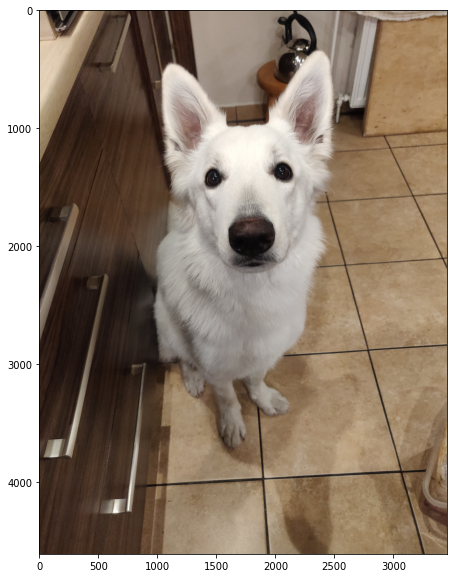

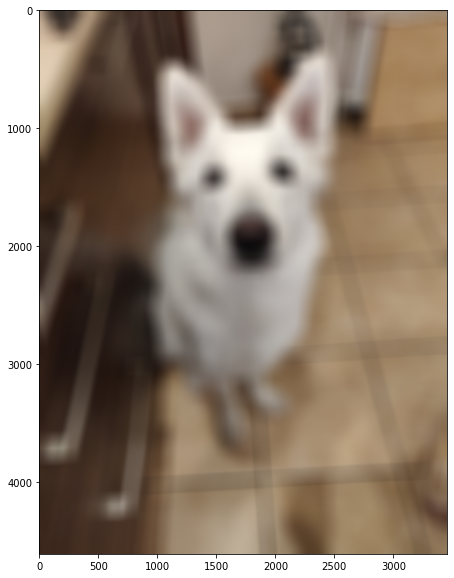

In [6]:
input_image = './example_image/1.jpg'

conCV = ConvolutionCV(input_image)
conCV.show_image()

blur = Filter("blur", 155).get()

out = conCV.conv([blur])
conCV.show_conv()

# CNN

### Dataset

The training archive contains 25,000 images of dogs and cats.

https://www.kaggle.com/c/dogs-vs-cats/data